# 🧠 Data Exploration - Robot Navigation Training Data

This notebook explores the generated training data for the 2D Point-Robot Navigator project.

## Objectives:
- Load and examine the training dataset
- Visualize sample environments and robot perceptions
- Analyze data distribution and quality
- Understand the relationship between 3x3 perceptions and actions


In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

from core.data_generation import load_training_data, visualize_environment, visualize_training_examples


## 1. Load Training Data


In [5]:
# Load the small training dataset
# X_train, y_train, metadata = load_training_data("../data/raw/small_training_dataset.npz")
# Load the large training dataset
X_train, y_train, metadata = load_training_data("../data/raw/large_training_dataset.npz")

print(f"Dataset loaded successfully!")
print(f"Input shape: {X_train.shape}")
print(f"Output shape: {y_train.shape}")
print(f"Number of environments: {len(metadata)}")

# Basic data validation
print(f"\n🔍 Data Quality Check:")
print(f"Input data type: {X_train.dtype}")
print(f"Output data type: {y_train.dtype}")
print(f"Input value range: {X_train.min()} - {X_train.max()}")
print(f"Output value range: {y_train.min()} - {y_train.max()}")
print(f"Missing values: {np.isnan(X_train).any() or np.isnan(y_train).any()}")


📂 Training data loaded from ../data/raw/large_training_dataset.npz
Dataset loaded successfully!
Input shape: (8619, 9)
Output shape: (8619,)
Number of environments: 1000

🔍 Data Quality Check:
Input data type: float32
Output data type: int8
Input value range: 0.0 - 1.0
Output value range: 0 - 3
Missing values: False


## 2. Action Distribution Analysis

**Key Questions:**
- Are all actions represented equally? (Class balance)
- What's the distribution across different actions?
- Are there any dominant patterns?


📊 Action Distribution:
    UP: 2202 ( 25.5%)
  DOWN: 2136 ( 24.8%)
  LEFT: 2160 ( 25.1%)
 RIGHT: 2121 ( 24.6%)

🎯 Class Balance Assessment:
Imbalance ratio: 1.04
Balance status: ✅ Good


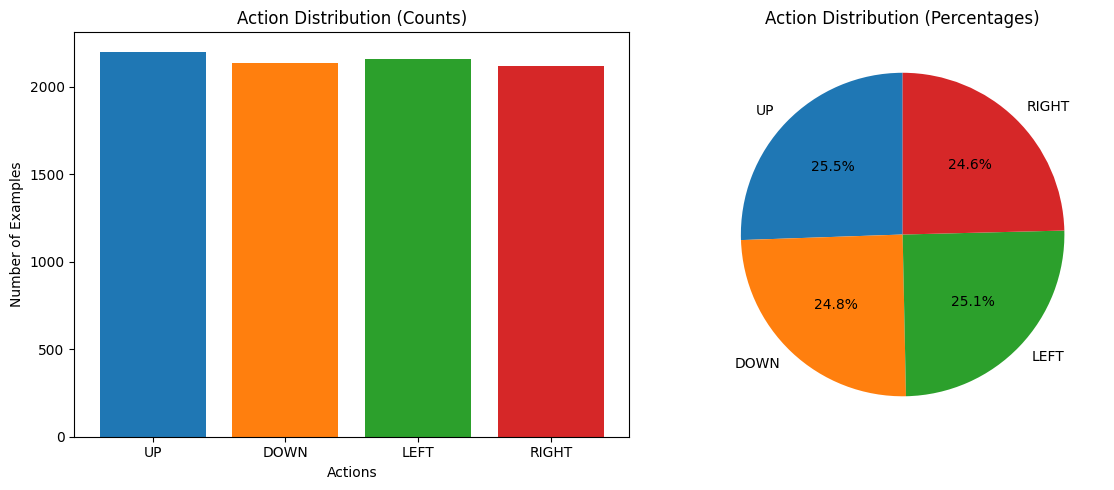

In [4]:
# Action distribution analysis
action_counts = np.bincount(y_train.astype(int))
action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']

print("📊 Action Distribution:")
print("=" * 40)
for name, count in zip(action_names, action_counts):
    percentage = (count / len(y_train)) * 100
    print(f"{name:>6}: {count:>4} ({percentage:>5.1f}%)")

# Class balance assessment
max_count = np.max(action_counts)
min_count = np.min(action_counts)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\n🎯 Class Balance Assessment:")
print(f"Imbalance ratio: {imbalance_ratio:.2f}")
print(f"Balance status: {'✅ Good' if imbalance_ratio <= 2 else '⚠️ Imbalanced'}")

# Visualize action distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
ax1.bar(action_names, action_counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax1.set_title('Action Distribution (Counts)')
ax1.set_ylabel('Number of Examples')
ax1.set_xlabel('Actions')

# Pie chart
ax2.pie(action_counts, labels=action_names, autopct='%1.1f%%', startangle=90)
ax2.set_title('Action Distribution (Percentages)')

plt.tight_layout()
plt.show()


## 3. Robot Perception Analysis

**Key Questions:**
- What does the robot actually "see" in its 3x3 window?
- How many obstacles are typically in the robot's view?
- Are there patterns in obstacle placement that affect actions?
- What's the relationship between perception and action?


👁️ Robot Perception Analysis:
Average obstacles per 3x3 view: 2.05
Max obstacles in any view: 6
Min obstacles in any view: 0
Most common obstacle count: 1

Obstacle Count Distribution:
  0 obstacles:   91 examples ( 10.8%)
  1 obstacles:  255 examples ( 30.3%)
  2 obstacles:  192 examples ( 22.8%)
  3 obstacles:  163 examples ( 19.4%)
  4 obstacles:  105 examples ( 12.5%)
  5 obstacles:   34 examples (  4.0%)
  6 obstacles:    1 examples (  0.1%)


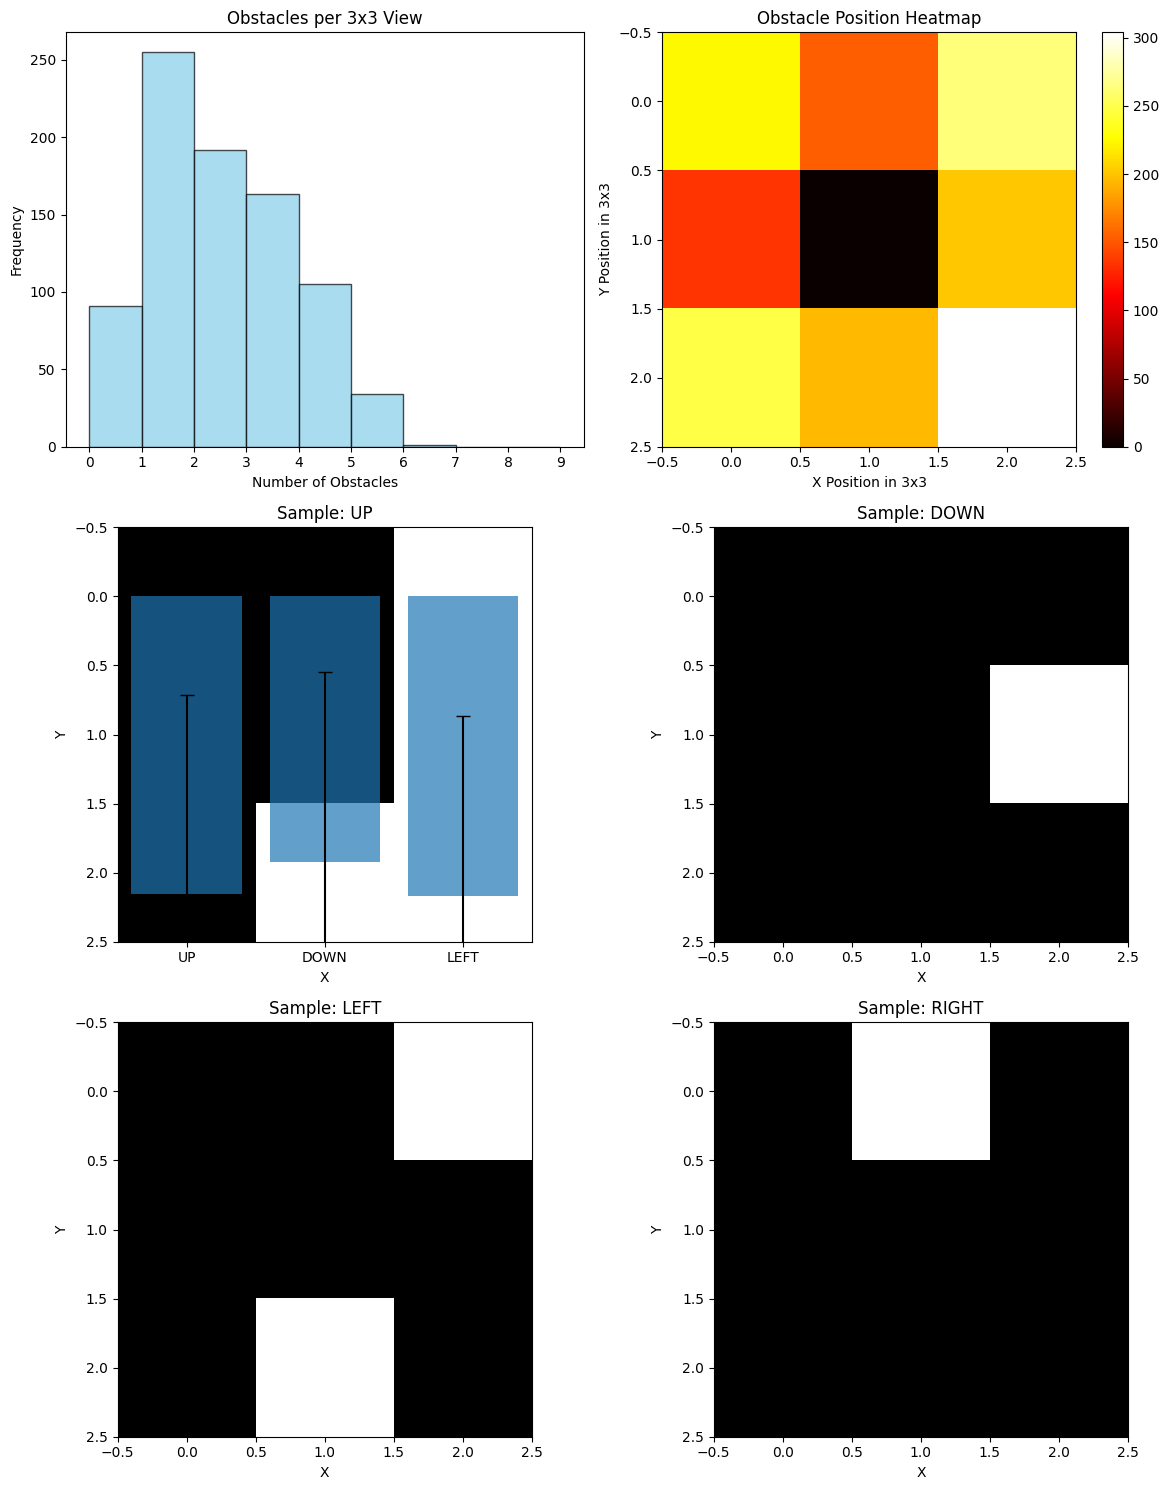

In [11]:
# Analyze 3x3 perceptions
obstacles_per_view = np.sum(X_train, axis=1).astype(int)  # Convert to int for bincount

print("👁️ Robot Perception Analysis:")
print("=" * 50)
print(f"Average obstacles per 3x3 view: {np.mean(obstacles_per_view):.2f}")
print(f"Max obstacles in any view: {np.max(obstacles_per_view)}")
print(f"Min obstacles in any view: {np.min(obstacles_per_view)}")
print(f"Most common obstacle count: {np.argmax(np.bincount(obstacles_per_view))}")

# Obstacle distribution
obstacle_counts = np.bincount(obstacles_per_view)
print(f"\nObstacle Count Distribution:")
for i, count in enumerate(obstacle_counts):
    percentage = (count / len(X_train)) * 100
    print(f"  {i} obstacles: {count:>4} examples ({percentage:>5.1f}%)")

# Visualize perception patterns
fig, axes = plt.subplots(3, 2, figsize=(12, 15))

# Obstacles per view histogram
axes[0, 0].hist(obstacles_per_view, bins=range(10), alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Obstacles per 3x3 View')
axes[0, 0].set_xlabel('Number of Obstacles')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_xticks(range(10))

# Obstacle position heatmap (where obstacles appear most often)
obstacle_positions = np.sum(X_train, axis=0).reshape(3, 3)
im = axes[0, 1].imshow(obstacle_positions, cmap='hot', interpolation='nearest')
axes[0, 1].set_title('Obstacle Position Heatmap')
axes[0, 1].set_xlabel('X Position in 3x3')
axes[0, 1].set_ylabel('Y Position in 3x3')
plt.colorbar(im, ax=axes[0, 1])

# Action vs obstacles relationship
action_obstacle_stats = {}
for action in range(4):
    action_mask = y_train == action
    if np.any(action_mask):
        action_obstacles = obstacles_per_view[action_mask]
        action_obstacle_stats[action_names[action]] = {
            'mean': np.mean(action_obstacles),
            'std': np.std(action_obstacles),
            'count': np.sum(action_mask)
        }

# Plot mean obstacles per action
actions = list(action_obstacle_stats.keys())
means = [action_obstacle_stats[action]['mean'] for action in actions]
stds = [action_obstacle_stats[action]['std'] for action in actions]

axes[1, 0].bar(actions, means, yerr=stds, capsize=5, alpha=0.7)
axes[1, 0].set_title('Mean Obstacles per Action')
axes[1, 0].set_ylabel('Average Obstacles in 3x3 View')
axes[1, 0].set_xlabel('Actions')

# Sample perceptions for each action
sample_perceptions = {}
for action in range(4):
    action_mask = y_train == action
    if np.any(action_mask):
        # Get a random example of this action
        idx = np.random.choice(np.where(action_mask)[0])
        sample_perceptions[action_names[action]] = X_train[idx].reshape(3, 3)

# Show sample perceptions
for i, (action_name, perception) in enumerate(sample_perceptions.items()):
    row = 1
    col = i
    if i >= 2:
        row = 2
        col = i - 2
    
    axes[row, col].imshow(perception, cmap='gray', vmin=0, vmax=1)
    axes[row, col].set_title(f'Sample: {action_name}')
    axes[row, col].set_xlabel('X')
    axes[row, col].set_ylabel('Y')

plt.tight_layout()
plt.show()


## 4. Environment Complexity Analysis

**Key Questions:**
- How complex are the environments we generated?
- What's the relationship between environment complexity and action patterns?
- Are there environments that are too simple or too complex?


Available keys in metadata: ['env_idx', 'path_length', 'obstacle_count', 'obstacle_density']
🏗️ Environment Complexity Analysis:
Average complexity: 0.00
Complexity range: 0.00 - 0.00
Average obstacle density: 0.19
Average path length: 9.41


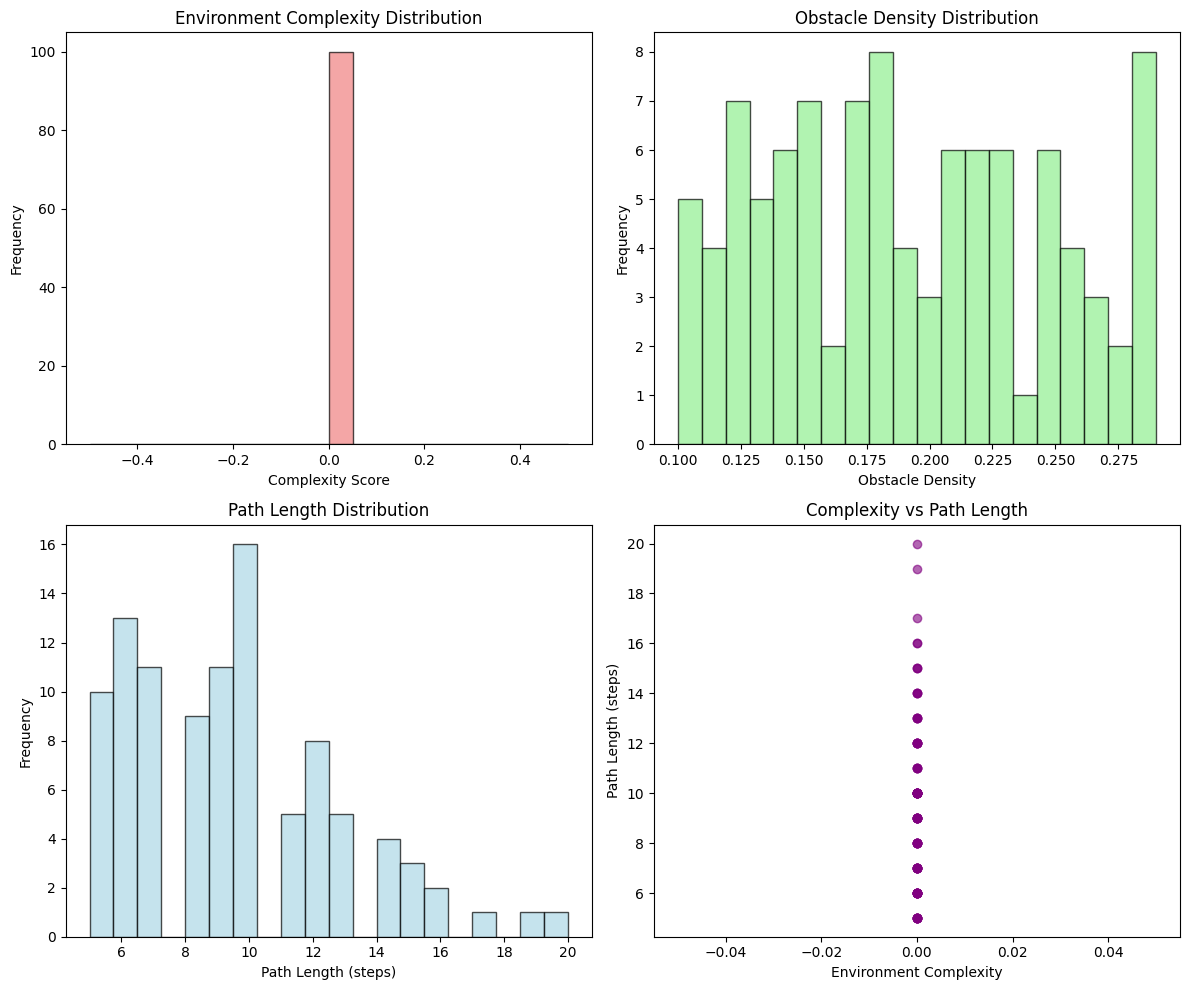

In [13]:
# Analyze environment complexity from metadata
# First, let's check what keys are available in metadata
print("Available keys in metadata:", list(metadata[0].keys()) if metadata else "No metadata")

env_complexities = []
env_obstacle_densities = []
env_path_lengths = []

for env_data in metadata:
    # Use available keys or set defaults
    env_complexities.append(env_data.get('complexity', 0))
    env_obstacle_densities.append(env_data.get('obstacle_density', 0))
    env_path_lengths.append(env_data.get('path_length', 0))

print("🏗️ Environment Complexity Analysis:")
print("=" * 50)
print(f"Average complexity: {np.mean(env_complexities):.2f}")
print(f"Complexity range: {np.min(env_complexities):.2f} - {np.max(env_complexities):.2f}")
print(f"Average obstacle density: {np.mean(env_obstacle_densities):.2f}")
print(f"Average path length: {np.mean(env_path_lengths):.2f}")

# Visualize environment characteristics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Complexity distribution
axes[0, 0].hist(env_complexities, bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 0].set_title('Environment Complexity Distribution')
axes[0, 0].set_xlabel('Complexity Score')
axes[0, 0].set_ylabel('Frequency')

# Obstacle density distribution
axes[0, 1].hist(env_obstacle_densities, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Obstacle Density Distribution')
axes[0, 1].set_xlabel('Obstacle Density')
axes[0, 1].set_ylabel('Frequency')

# Path length distribution
axes[1, 0].hist(env_path_lengths, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[1, 0].set_title('Path Length Distribution')
axes[1, 0].set_xlabel('Path Length (steps)')
axes[1, 0].set_ylabel('Frequency')

# Complexity vs Path Length
axes[1, 1].scatter(env_complexities, env_path_lengths, alpha=0.6, color='purple')
axes[1, 1].set_title('Complexity vs Path Length')
axes[1, 1].set_xlabel('Environment Complexity')
axes[1, 1].set_ylabel('Path Length (steps)')

plt.tight_layout()
plt.show()


## 4. Key Insights & Neural Network Implications

**What this data tells us about our neural network design:**


In [14]:
# Key insights from the data analysis
print("🧠 Key Insights for Neural Network Design:")
print("=" * 60)

print("\n1. 📊 DATA BALANCE:")
print(f"   • Action distribution is {'balanced' if imbalance_ratio <= 2 else 'imbalanced'}")
print(f"   • Imbalance ratio: {imbalance_ratio:.2f}")
print(f"   • Recommendation: {'No class balancing needed' if imbalance_ratio <= 2 else 'Consider class balancing techniques'}")

print("\n2. 👁️ PERCEPTION COMPLEXITY:")
print(f"   • Average obstacles per view: {np.mean(obstacles_per_view):.2f}")
print(f"   • Most common scenario: {np.argmax(obstacle_counts)} obstacles ({(np.argmax(obstacle_counts)/len(X_train)*100):.1f}%)")
print(f"   • Robot sees 0-6 obstacles in 3x3 window")
print(f"   • Recommendation: Network needs to handle sparse to dense obstacle scenarios")

print("\n3. 🎯 ACTION PATTERNS:")
print("   • Each action has different obstacle context")
print("   • Network must learn obstacle-action relationships")
print("   • Recommendation: Use convolutional layers to capture spatial patterns")

print("\n4. 🏗️ ENVIRONMENT DIVERSITY:")
print(f"   • {len(metadata)} different environments")
print(f"   • Complexity range: {np.min(env_complexities):.2f} - {np.max(env_complexities):.2f}")
print(f"   • Path lengths: {np.min(env_path_lengths)} - {np.max(env_path_lengths)} steps")
print(f"   • Recommendation: Good diversity for generalization")

print("\n5. 🔧 NEURAL NETWORK ARCHITECTURE RECOMMENDATIONS:")
print("   • Input: 9 features (3x3 flattened perception)")
print("   • Hidden layers: 2-3 layers with 32-64 neurons each")
print("   • Output: 4 classes (UP, DOWN, LEFT, RIGHT)")
print("   • Activation: ReLU for hidden, Softmax for output")
print("   • Loss: Categorical Crossentropy")
print("   • Regularization: Dropout (0.2-0.3) to prevent overfitting")

print("\n6. 📈 TRAINING STRATEGY:")
print("   • Start with simple environments (low complexity)")
print("   • Gradually increase difficulty")
print("   • Use data augmentation if needed")
print("   • Monitor for overfitting on specific obstacle patterns")


🧠 Key Insights for Neural Network Design:

1. 📊 DATA BALANCE:
   • Action distribution is balanced
   • Imbalance ratio: 1.25
   • Recommendation: No class balancing needed

2. 👁️ PERCEPTION COMPLEXITY:
   • Average obstacles per view: 2.05
   • Most common scenario: 1 obstacles (0.1%)
   • Robot sees 0-6 obstacles in 3x3 window
   • Recommendation: Network needs to handle sparse to dense obstacle scenarios

3. 🎯 ACTION PATTERNS:
   • Each action has different obstacle context
   • Network must learn obstacle-action relationships
   • Recommendation: Use convolutional layers to capture spatial patterns

4. 🏗️ ENVIRONMENT DIVERSITY:
   • 100 different environments
   • Complexity range: 0.00 - 0.00
   • Path lengths: 5 - 20 steps
   • Recommendation: Good diversity for generalization

5. 🔧 NEURAL NETWORK ARCHITECTURE RECOMMENDATIONS:
   • Input: 9 features (3x3 flattened perception)
   • Hidden layers: 2-3 layers with 32-64 neurons each
   • Output: 4 classes (UP, DOWN, LEFT, RIGHT)
   

## 5. Next Steps: Neural Network Development

**Based on this analysis, here's how to proceed:**


In [10]:
print("🚀 NEXT STEPS FOR NEURAL NETWORK DEVELOPMENT:")
print("=" * 60)

print("\n📋 IMMEDIATE ACTIONS:")
print("1. Create neural network architecture in core/neural_network.py")
print("2. Implement training script in scripts/train_model.py")
print("3. Add model evaluation in notebooks/02_model_evaluation.ipynb")
print("4. Create visualization tools for training progress")

print("\n🏗️ ARCHITECTURE DESIGN:")
print("• Input Layer: 9 neurons (3x3 perception)")
print("• Hidden Layer 1: 64 neurons + ReLU + Dropout(0.2)")
print("• Hidden Layer 2: 32 neurons + ReLU + Dropout(0.2)")
print("• Output Layer: 4 neurons + Softmax")

print("\n📊 TRAINING PLAN:")
print("• Split data: 80% train, 20% validation")
print("• Batch size: 32-64")
print("• Learning rate: 0.001 with decay")
print("• Epochs: 50-100 with early stopping")
print("• Monitor: accuracy, loss, confusion matrix")

print("\n🔍 EVALUATION METRICS:")
print("• Overall accuracy")
print("• Per-action accuracy")
print("• Confusion matrix")
print("• Training vs validation curves")
print("• Test on new environments")

print("\n💡 BIOLOGICAL CONNECTIONS:")
print("• Mimics how animals learn navigation")
print("• 3x3 perception = local sensory input")
print("• Action selection = motor cortex decision")
print("• Learning = synaptic plasticity")


🚀 NEXT STEPS FOR NEURAL NETWORK DEVELOPMENT:

📋 IMMEDIATE ACTIONS:
1. Create neural network architecture in core/neural_network.py
2. Implement training script in scripts/train_model.py
3. Add model evaluation in notebooks/02_model_evaluation.ipynb
4. Create visualization tools for training progress

🏗️ ARCHITECTURE DESIGN:
• Input Layer: 9 neurons (3x3 perception)
• Hidden Layer 1: 64 neurons + ReLU + Dropout(0.2)
• Hidden Layer 2: 32 neurons + ReLU + Dropout(0.2)
• Output Layer: 4 neurons + Softmax

📊 TRAINING PLAN:
• Split data: 80% train, 20% validation
• Batch size: 32-64
• Learning rate: 0.001 with decay
• Epochs: 50-100 with early stopping
• Monitor: accuracy, loss, confusion matrix

🔍 EVALUATION METRICS:
• Overall accuracy
• Per-action accuracy
• Confusion matrix
• Training vs validation curves
• Test on new environments

💡 BIOLOGICAL CONNECTIONS:
• Mimics how animals learn navigation
• 3x3 perception = local sensory input
• Action selection = motor cortex decision
• Learning =